# **ML Methodları ile Meme Kanseri Tanı Projesi**

**Proje Hedefi:** Bu notebook, bir veri bilimi projesinin sıfırdan nasıl ele alındığını, production'a (üretim ortamı) hazır, sağlam bir modelin nasıl geliştirildiğini adım adım göstermektedir. 

**Seneryo:**  Bir meme kitlesinin ince iğne aspirasyonunun sayısallaştırılmış görüntüsünden oluşan verilerini kullanarak, bir hastanın sahip olduğu hücrenin Beningn (İyi Huylu) veya Malignant (Kötü Huylu) tanısını tahmin eden bir makine öğrenmesi modeli geliştireceğiz.

**Proje Adımları**: 

1. **Problem Tanımlama:** İş hedefi anlama.
2. **Veri Toplama ve Yükeleme:** Gerekli kütüphanlerim tanımlanması ve verinin yüklenmesi.
3. **Keşifsel Veri Analizi (EDA):** Veriyi anlama, görselleştirme ve içgörüler çıkarma.
4. **Özellik Mühendisliği (Feature Engineering):** Mevcut verilerden anlamlı, model verimini arttıran özellikler türetilmesi.
5. **Veri Hazırlama (Preprocessing):** Modellerin anlyacağı formata getirme (Train/Test).
6. **Pipeline Oluşturma:** Veri işleme akışını otomatikleştirme, yeni gelecek veriye ortamı hazırlama.
7. **Model Seçimi ve Baseline:** Farklı modelleri test etme.
8. **Hiperparametre Optimizasyonu:** En iyi modeli ``GridSearchCV`` ile optimize etme.
9. **Model Açıklanabilirliği**: SHAP Analizi
10. **Final Model Değerlendirmesi:** Modeli test verisi üzerinden değerlendirme.
11. **Modeli Kaydetme ve Yeni Tahmin:** Eğitilmiş pipeline' ı kaydetme ve yeni veriler üzerinden tahmin yapma.

---

## ADIM 1: Problem Tanımlama
- **İş Problemi:** Göğüs kanseri verisi üzerinden hangi hücrenin İyi huylu veya Kötü huylu olduğunu, hangi özelliklerin (seffaflık ortalaması, cap ortalaması, doku ortalamsı) buna etki ettiğini ve yeni hasta değerleri üzerinden (veya bu veri seti üzerinden) hasta hücresinin hangi sınıfta olma olasılığını tahmin etmek.
- **Hedef Değişken:** `diagnosis` (0 = Benign, 1 = Malignant)
- **Problem Tipi:** Bu bir **Binary Classification (İkili Sınıflandırma)** problemidir.
- **Başarı Metriği:** ``Accuracy`` (Doğruluk) genel bir başarı ölçütüdür. Ancak, ``Precision``, ``Recall`` ve ``F1-Score`` da dengesiz sınıflar için önemlidir. Biz ``Accuracy`` ve ``F1-Score`` üzerine odaklanacağız.

## ADIM 2: Veri Toplama ve Yükleme

Gerekli tüm kütüphanleri ve verileri yüklüyoruz.


In [98]:
#Gerekli Kütüphanler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Scikit-learn Kütüphaneleri
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
# Değerlendirme Metriği Kütüphaneleri
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score, precision_score, recall_score
)
# Modelleme Kütüphaneleri
import pickle
import os
# Explainable AI Kütüphanesi
import shap
#Modeller
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
# Ayarlar
pd.set_option('display.max_columns', None)  # Tüm sütunları göster
pd.set_option('display.max_rows', None)     # Gerekirse tüm satırları göster
pd.set_option('display.width', None)        # Satırı bölmeden yaz
pd.set_option('display.max_colwidth', None) # Sütun isimlerini kesme

import warnings
warnings.filterwarnings('ignore')

In [99]:
# Veri Yükleme
# Eğer "data.csv" dosyası yerel olarak yoksa, veriyi internetten çek
try:
    df = pd.read_csv("data.csv")
except FileNotFoundError:
    print("Dosya bulunamadı. Veri internetten çekiliyor...")
    df = pd.read_csv('https://www.kaggle.com/api/v1/datasets/download/uciml/breast-cancer-wisconsin-data/data.csv')
print("Veri seti başarıyla yüklendi.")

Dosya bulunamadı. Veri internetten çekiliyor...
Veri seti başarıyla yüklendi.


## ADIM 3: Keşifsel Veri Analizi (EDA)
Veriyi anlamak için en kritik adımdır.

In [100]:
# Veri Seti Hakkında Genel Bilgi
print("Veri Seti Boyutu:", df.shape)
print("Veri Seti İlk 5 Satır:")
df.head()

Veri Seti Boyutu: (569, 33)
Veri Seti İlk 5 Satır:


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [101]:
print("Sütun Bilgileri:", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [102]:
print(f"Hedef Değişken Dağılımı:{df['diagnosis'].value_counts()}")
print(f"Hedef Değişken Oranları:{df['diagnosis'].value_counts(normalize=True)*100}")

Hedef Değişken Dağılımı:diagnosis
B    357
M    212
Name: count, dtype: int64
Hedef Değişken Oranları:diagnosis
B    62.741652
M    37.258348
Name: proportion, dtype: float64


In [103]:
#Eksik Değer Kontrolü
print("Eksik Değer Kontrolü")
print(df.isnull().sum()[df.isnull().sum() > 0])

Eksik Değer Kontrolü
Unnamed: 32    569
dtype: int64


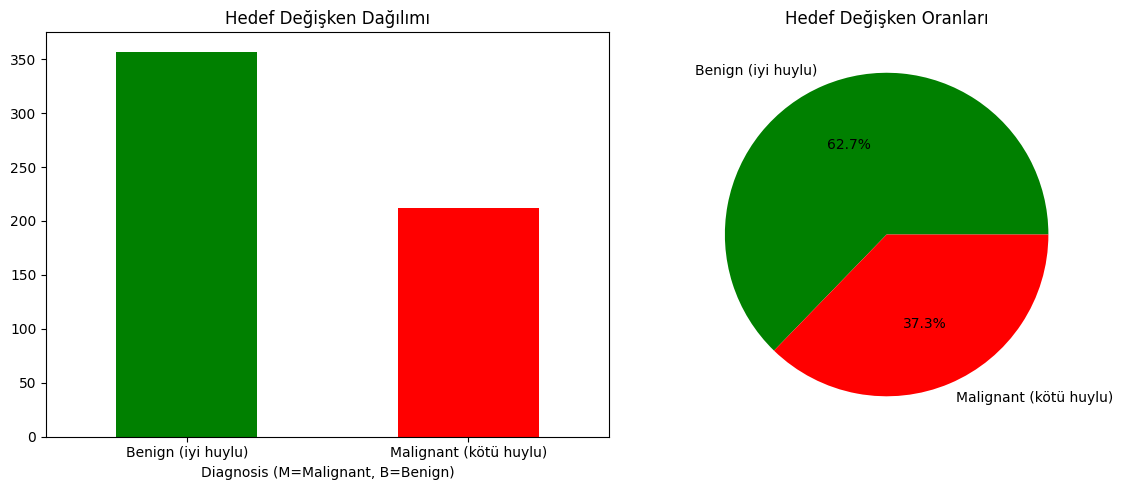

In [104]:
# Hedef Değişken Dağılımı ve Oranları
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df['diagnosis'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Hedef Değişken Dağılımı')
axes[0].set_xlabel('Diagnosis (M=Malignant, B=Benign)')
axes[0].set_ylabel = ('Sayı')
axes[0].set_xticklabels(['Benign (iyi huylu)', 'Malignant (kötü huylu)'], rotation=0)

df["diagnosis"].value_counts(normalize=True).plot(kind = 'pie', ax=axes[1], 
                                                          autopct='%1.1f%%', colors=['green', 'red'], 
                                                          labels = ['Benign (iyi huylu)', 'Malignant (kötü huylu)'])
axes[1].set_title('Hedef Değişken Oranları')
axes[1].set_ylabel('')
plt.tight_layout()
plt.savefig("graphs/diagnosis_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

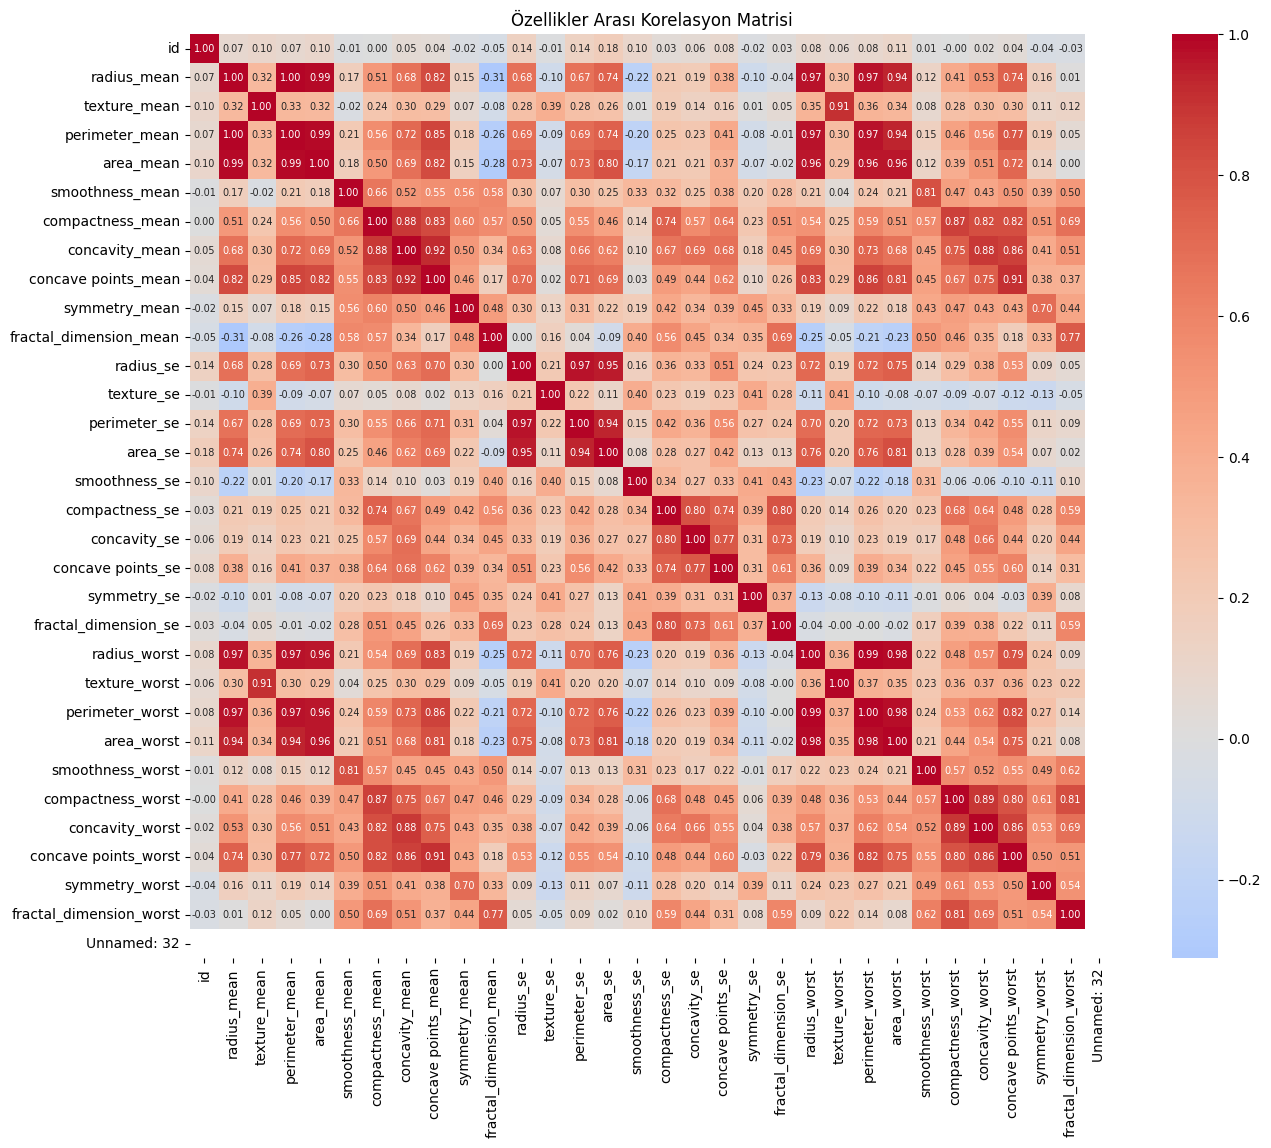

In [105]:
# Korelasyon Matrisi
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numerical_cols].corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap='coolwarm', center = 0, fmt = ".2f", annot=True, square=True, annot_kws={"size": 7})
plt.title('Özellikler Arası Korelasyon Matrisi')
plt.savefig("graphs/correlation_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

In [106]:
df_clean = df.copy()
df_clean = df_clean.drop(columns=['id', 'Unnamed: 32']) # Gereksiz sütunları kaldırma

encoder = LabelEncoder()
df_clean['diagnosis'] = encoder.fit_transform(df_clean['diagnosis']) # Hedef değişkeni sayısal hale getirme (M=1, B=0)
df_clean.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [107]:
print("Özellik Bazında Temel İstatistikler:")
df_clean.describe()

Özellik Bazında Temel İstatistikler:


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [108]:
X = df_clean.drop('diagnosis', axis=1)
y = df_clean['diagnosis']

print("Özellikler Boyutu:", X.shape)
print("Hedef Değişken Boyutu:", y.shape)

Özellikler Boyutu: (569, 30)
Hedef Değişken Boyutu: (569,)


                         Aykırı Değer Sayısı
area_se                                   65
radius_se                                 38
perimeter_se                              38
area_worst                                35
smoothness_se                             30
fractal_dimension_se                      28
compactness_se                            28
symmetry_se                               27
area_mean                                 25
fractal_dimension_worst                   24
symmetry_worst                            23
concavity_se                              22
texture_se                                20
concave points_se                         19
concavity_mean                            18


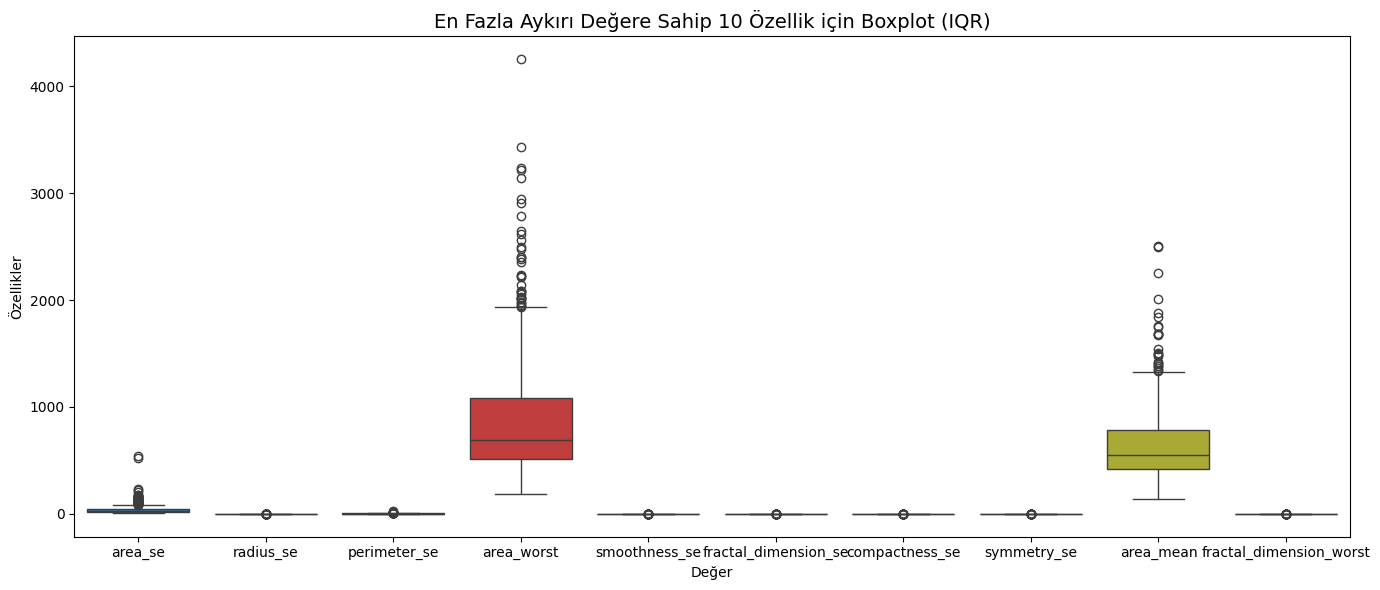

In [109]:
def count_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers)

outlier_counts = {}
for col in X.columns:
    outlier_counts[col] = count_outliers_iqr(df_clean, col)

outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Aykırı Değer Sayısı'])
outlier_df = outlier_df.sort_values('Aykırı Değer Sayısı', ascending=False)
print(outlier_df.head(15))

top10_features = outlier_df.head(10).index.tolist()

plt.figure(figsize=(14, 6))

sns.boxplot(
    data=df_clean[top10_features],
)

plt.title("En Fazla Aykırı Değere Sahip 10 Özellik için Boxplot (IQR)", fontsize=14)
plt.xlabel("Değer")
plt.ylabel("Özellikler")
plt.tight_layout()
plt.savefig("graphs/top10_outliers_boxplot.png", dpi=150, bbox_inches='tight')
plt.show()

### Analiz ve Yorumlama
1. **Gereksiz Özellikler:** Veri setini incelediğimizde gereksiz olan ``id`` ve `Unnamed: 32` adında iki tane özellik görüyoruz. Bunlar modeli eğitme aşamasında her hangi bir yardımları olmayacağı için kaldırıyoruz. 
1. **Hedef Değişkeni Encode Etme:** Hedef değişken `diagnosis` incelediğinde değerlerinin `M` ve `B` olduklarını görüyoruz. Modeller hedef değişken değerlerini sayı olarak istedikleri için bu özelliğe `LabelEncoder` uyguluyoruz
2. **Aykırı Değerler**: IQR yöntemi uyguladığımız bazı aykırı değerler görüyoruz. Örneğin ``area_worst``, grafiğe göre yaklaşık 2000 üzeri değerlerde bazı "aykırı" noktalar görüyoruz. En fazla aykırı değere sahip sahip ilk 10 özellik listelendi. 
 - **Bu bir hata mı ?** Hayır. Çünkü bunun gibi medikal verilerde böyle uç değerlerle karşılaşmamız çok olası. Bu veri seti için en optimum olanı özellikleri baskılamadan modele sokmak olur. 

## ADIM 4: Özellik Mühendisliği (Feature Engineering)
EDA' dan elde ettiğimiz veya alan bilgilerimizle yeni özellikler yaratırız. Pipeline içinde kullanım için class olarak tanımlıyoruz.

In [110]:
#Feature Engineering Transformer (Pipeline için)
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_ = None
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.feature_names_ = X.columns.tolist()
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            if self.feature_names_:
                X = pd.DataFrame(X, columns=self.feature_names_)
            else:
                X = pd.DataFrame(X)
        
        X = X.copy()
        
        if 'radius_mean' in X.columns and 'area_mean' in X.columns:
            X['radius_area_ratio'] = X['radius_mean'] / (X['area_mean'] + 1e-6)
        
        if 'perimeter_mean' in X.columns and 'area_mean' in X.columns:
            X['perimeter_area_ratio'] = X['perimeter_mean'] / (X['area_mean'] + 1e-6)
        
        if 'concavity_mean' in X.columns and 'concave points_mean' in X.columns:
            X['concavity_points_product'] = X['concavity_mean'] * X['concave points_mean']
        
        return X
print("FeatureEngineeringTransformer tanımlandı.")

FeatureEngineeringTransformer tanımlandı.


## ADIM 5: Veri Hazırlama ve Pipeline için Ayırma
Artık veriyi modellemeye hazırlayabiliriz.

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Eğitim Özellikleri Boyutu:", X_train.shape)
print("Test Özellikleri Boyutu:", X_test.shape)
print("Eğitim Hedef Değişken Boyutu:", y_train.shape)
print("Test Hedef Değişken Boyutu:", y_test.shape)

Eğitim Özellikleri Boyutu: (455, 30)
Test Özellikleri Boyutu: (114, 30)
Eğitim Hedef Değişken Boyutu: (455,)
Test Hedef Değişken Boyutu: (114,)


In [112]:
# Preprocessing Pipeline Oluşturma
preprocessing_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('scaler', StandardScaler())
])
X_train_scaled = preprocessing_pipeline.fit_transform(X_train)
X_test_scaled = preprocessing_pipeline.transform(X_test)

# DataFrame olarak geri dönüştürme
feature_eng = FeatureEngineeringTransformer().fit_transform(X_train)
feature_names = feature_eng.columns.tolist()

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

print(f"Pipeline ile preprocessing tamamlandı.")
print(f"Eğitim seti şekli: {X_train_scaled.shape}")
print(f"Test seti şekli: {X_test_scaled.shape}")
print(f"Yeni özellikler: {[col for col in X_train_scaled.columns if col not in X_train.columns]}")
print("Artık tüm preprocessing pipeline ile yapılıyor!")

Pipeline ile preprocessing tamamlandı.
Eğitim seti şekli: (455, 33)
Test seti şekli: (114, 33)
Yeni özellikler: ['radius_area_ratio', 'perimeter_area_ratio', 'concavity_points_product']
Artık tüm preprocessing pipeline ile yapılıyor!


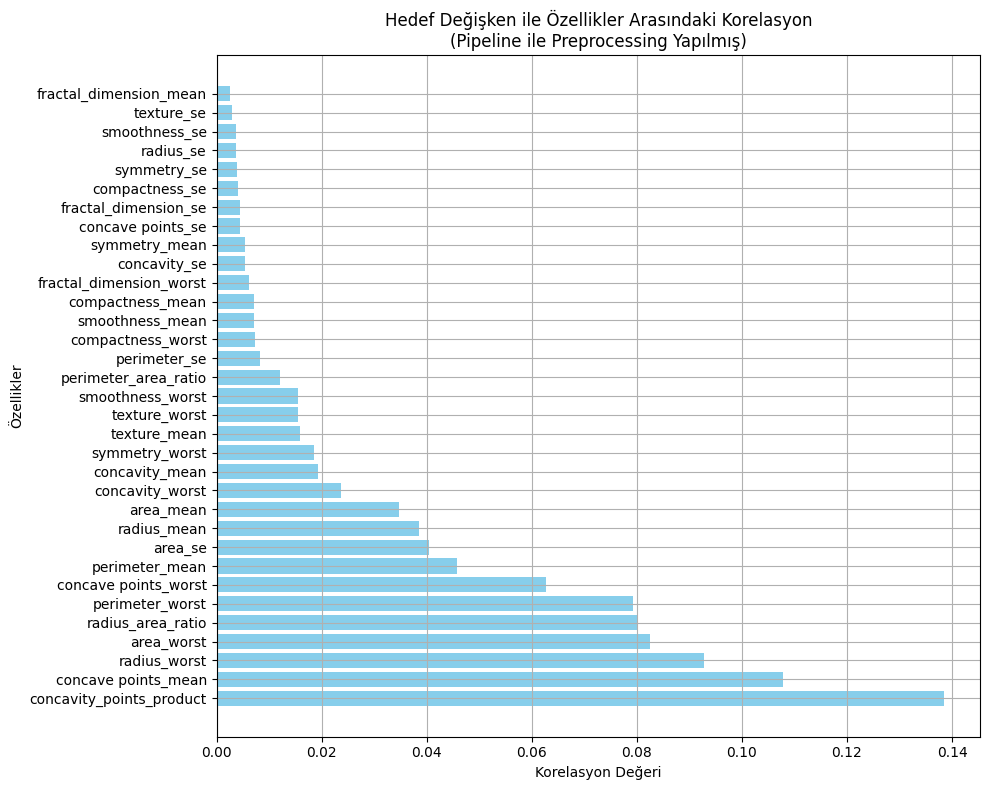

En Yüksek Korelasyona Sahip 10 Özellik:
                     feature  importance
32  concavity_points_product    0.138400
7        concave points_mean    0.107771
20              radius_worst    0.092711
23                area_worst    0.082492
30         radius_area_ratio    0.079964
22           perimeter_worst    0.079235
27      concave points_worst    0.062795
2             perimeter_mean    0.045789
13                   area_se    0.040354
0                radius_mean    0.038474


In [113]:
# Hedef Değişken ile Özellikler Arasındaki Korelasyon (Pipeline ile Preprocessing Yapılmış)
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.title('Hedef Değişken ile Özellikler Arasındaki Korelasyon\n(Pipeline ile Preprocessing Yapılmış)')
plt.xlabel('Korelasyon Değeri')
plt.ylabel('Özellikler')
plt.grid()
plt.tight_layout()
plt.savefig("graphs/target_correlation.png", dpi=150, bbox_inches='tight')
plt.show()
print("En Yüksek Korelasyona Sahip 10 Özellik:")
print(feature_importance.head(10))

### **Analiz ve Yorumlama**

1. **Tümor şekli ve düzensizliği ile ilegli özellikşer çok belirleyici**
    - `concavity_points_product`, `concave points_mean` ve `concave points_worst ` gibi özellikler, hedef değişkeni tahmin etmede en yüksek öneme sahip özelliklerdendir
    - Yani, kötü huylu tümorlerin yüzey geometrisinin daha düzensiz ve girintili çıkıntılı (concavity/concave points) olma eğilimini, bu düzensizliğin kötü huylu göstergesi olarak kullanıldığıni göstermektedir.
2. **Boyut ve alan ölçümleri kötü huyluyu güçlü şekilde ayırt ediyor**
    - ``radius_worst``, ``area_worst``, ``perimeter_worst``, ``perimeter_mean`` ve ``radius_mean`` gibi özellikler de baskın.
    - Bu da daha büyük çaplı, çevre uzunluğu fazla ve geniş alanlı kitlelerin kötü huylu olma olasılığının daha yüksek olmasına işaret eder.
    - `area_se`' de tümor alanındaki değişlenliğin model için anlamlı olduğunu gösterir.
3. **Feture engineering ile türetilen özellikler**
    - `concavity_points_product` özelliğinin özellik önemleri sıralandığında ikinci sırada görünmesi modeli zenginleştirdiği ve tahmin gücüne büyük katkısı olduğunun gösterir.
    - `radius_area_ratio` ise tümorun yarıçapı ve alanının oranı göz önünde bulunrulduğunda, hücreyi çok iyi açıkladığını görebiliriz
    - Diğer ürettiğimiz `parimeter_area_ratio` ilk 10' da yerini alamasada grafikten onlarında bu karar mekanizmasında önemli oladuklarını görebiliriz.

## ADIM 6: Model Seçimi ve Baseline
Farklı modelleri test ederek aralarındaki en iyi adayı belirlemeyelim.

In [114]:
results = {}

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    "XGBoost": xgb.XGBClassifier(n_estimatoers=200, learning_rate=0.1, max_depth = 5, 
                                 random_state=42, evaluation_metric='logloss', use_label_encoder=False),
    "LigthtGBM": lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1)
}

In [115]:
print("Modeller eğitiliyor...")
for model_name, model in models.items():
    print(f"{model_name} modeli eğitiliyor...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    results[model_name] = {
        'model_name': model,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'CV_Mean': cv_mean,
        'CV_Std': cv_std,
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}, CV Mean: {cv_mean:.4f}")

Modeller eğitiliyor...
Logistic Regression modeli eğitiliyor...
Accuracy: 0.9737, Precision: 0.9756, Recall: 0.9524, F1-Score: 0.9639, ROC-AUC: 0.9964, CV Mean: 0.9736
Decision Tree modeli eğitiliyor...
Accuracy: 0.9123, Precision: 0.9211, Recall: 0.8333, F1-Score: 0.8750, ROC-AUC: 0.8958, CV Mean: 0.9187
Random Forest modeli eğitiliyor...
Accuracy: 0.9649, Precision: 1.0000, Recall: 0.9048, F1-Score: 0.9500, ROC-AUC: 0.9940, CV Mean: 0.9560
Gradient Boosting modeli eğitiliyor...
Accuracy: 0.9737, Precision: 1.0000, Recall: 0.9286, F1-Score: 0.9630, ROC-AUC: 0.9921, CV Mean: 0.9626
SVM modeli eğitiliyor...
Accuracy: 0.9737, Precision: 0.9756, Recall: 0.9524, F1-Score: 0.9639, ROC-AUC: 0.9950, CV Mean: 0.9736
KNN modeli eğitiliyor...
Accuracy: 0.9561, Precision: 0.9744, Recall: 0.9048, F1-Score: 0.9383, ROC-AUC: 0.9828, CV Mean: 0.9648
Naive Bayes modeli eğitiliyor...
Accuracy: 0.9386, Precision: 0.9730, Recall: 0.8571, F1-Score: 0.9114, ROC-AUC: 0.9934, CV Mean: 0.9473
XGBoost modeli e

In [116]:
model_comparison_df = pd.DataFrame({
    "Model" : list(results.keys()),
    "Accuracy": [results[model]['Accuracy'] for model in results.keys()],
    "Precision": [results[model]['Precision'] for model in results.keys()],
    "Recall": [results[model]['Recall'] for model in results.keys()],
    "F1-Score": [results[model]['F1-Score'] for model in results.keys()],
    "ROC-AUC": [results[model]['ROC-AUC'] for model in results.keys()],
    "CV_Mean": [results[model]['CV_Mean'] for model in results.keys()],
    "CV_Std": [results[model]['CV_Std'] for model in results.keys()]
}).sort_values(by='F1-Score', ascending=False)

print("\n" + model_comparison_df.to_string(index=False))


              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  CV_Mean   CV_Std
Logistic Regression  0.973684   0.975610 0.952381  0.963855 0.996362 0.973626 0.014906
                SVM  0.973684   0.975610 0.952381  0.963855 0.995040 0.973626 0.013187
  Gradient Boosting  0.973684   1.000000 0.928571  0.962963 0.992063 0.962637 0.028317
            XGBoost  0.973684   1.000000 0.928571  0.962963 0.991402 0.964835 0.029812
      Random Forest  0.964912   1.000000 0.904762  0.950000 0.994048 0.956044 0.031849
          LigthtGBM  0.964912   1.000000 0.904762  0.950000 0.995370 0.964835 0.030612
                KNN  0.956140   0.974359 0.904762  0.938272 0.982804 0.964835 0.020143
        Naive Bayes  0.938596   0.972973 0.857143  0.911392 0.993386 0.947253 0.023466
      Decision Tree  0.912281   0.921053 0.833333  0.875000 0.895833 0.918681 0.035845


In [117]:
best_model_name = model_comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model_name']
print(f"\nEn İyi Model: {best_model_name}")
print(f"F1-Score: {results[best_model_name]['F1-Score']:.4f}")
print(f"Accuracy: {results[best_model_name]['Accuracy']:.4f}")
print(f"ROC-AUC: {results[best_model_name]['ROC-AUC']:.4f}")



En İyi Model: Logistic Regression
F1-Score: 0.9639
Accuracy: 0.9737
ROC-AUC: 0.9964


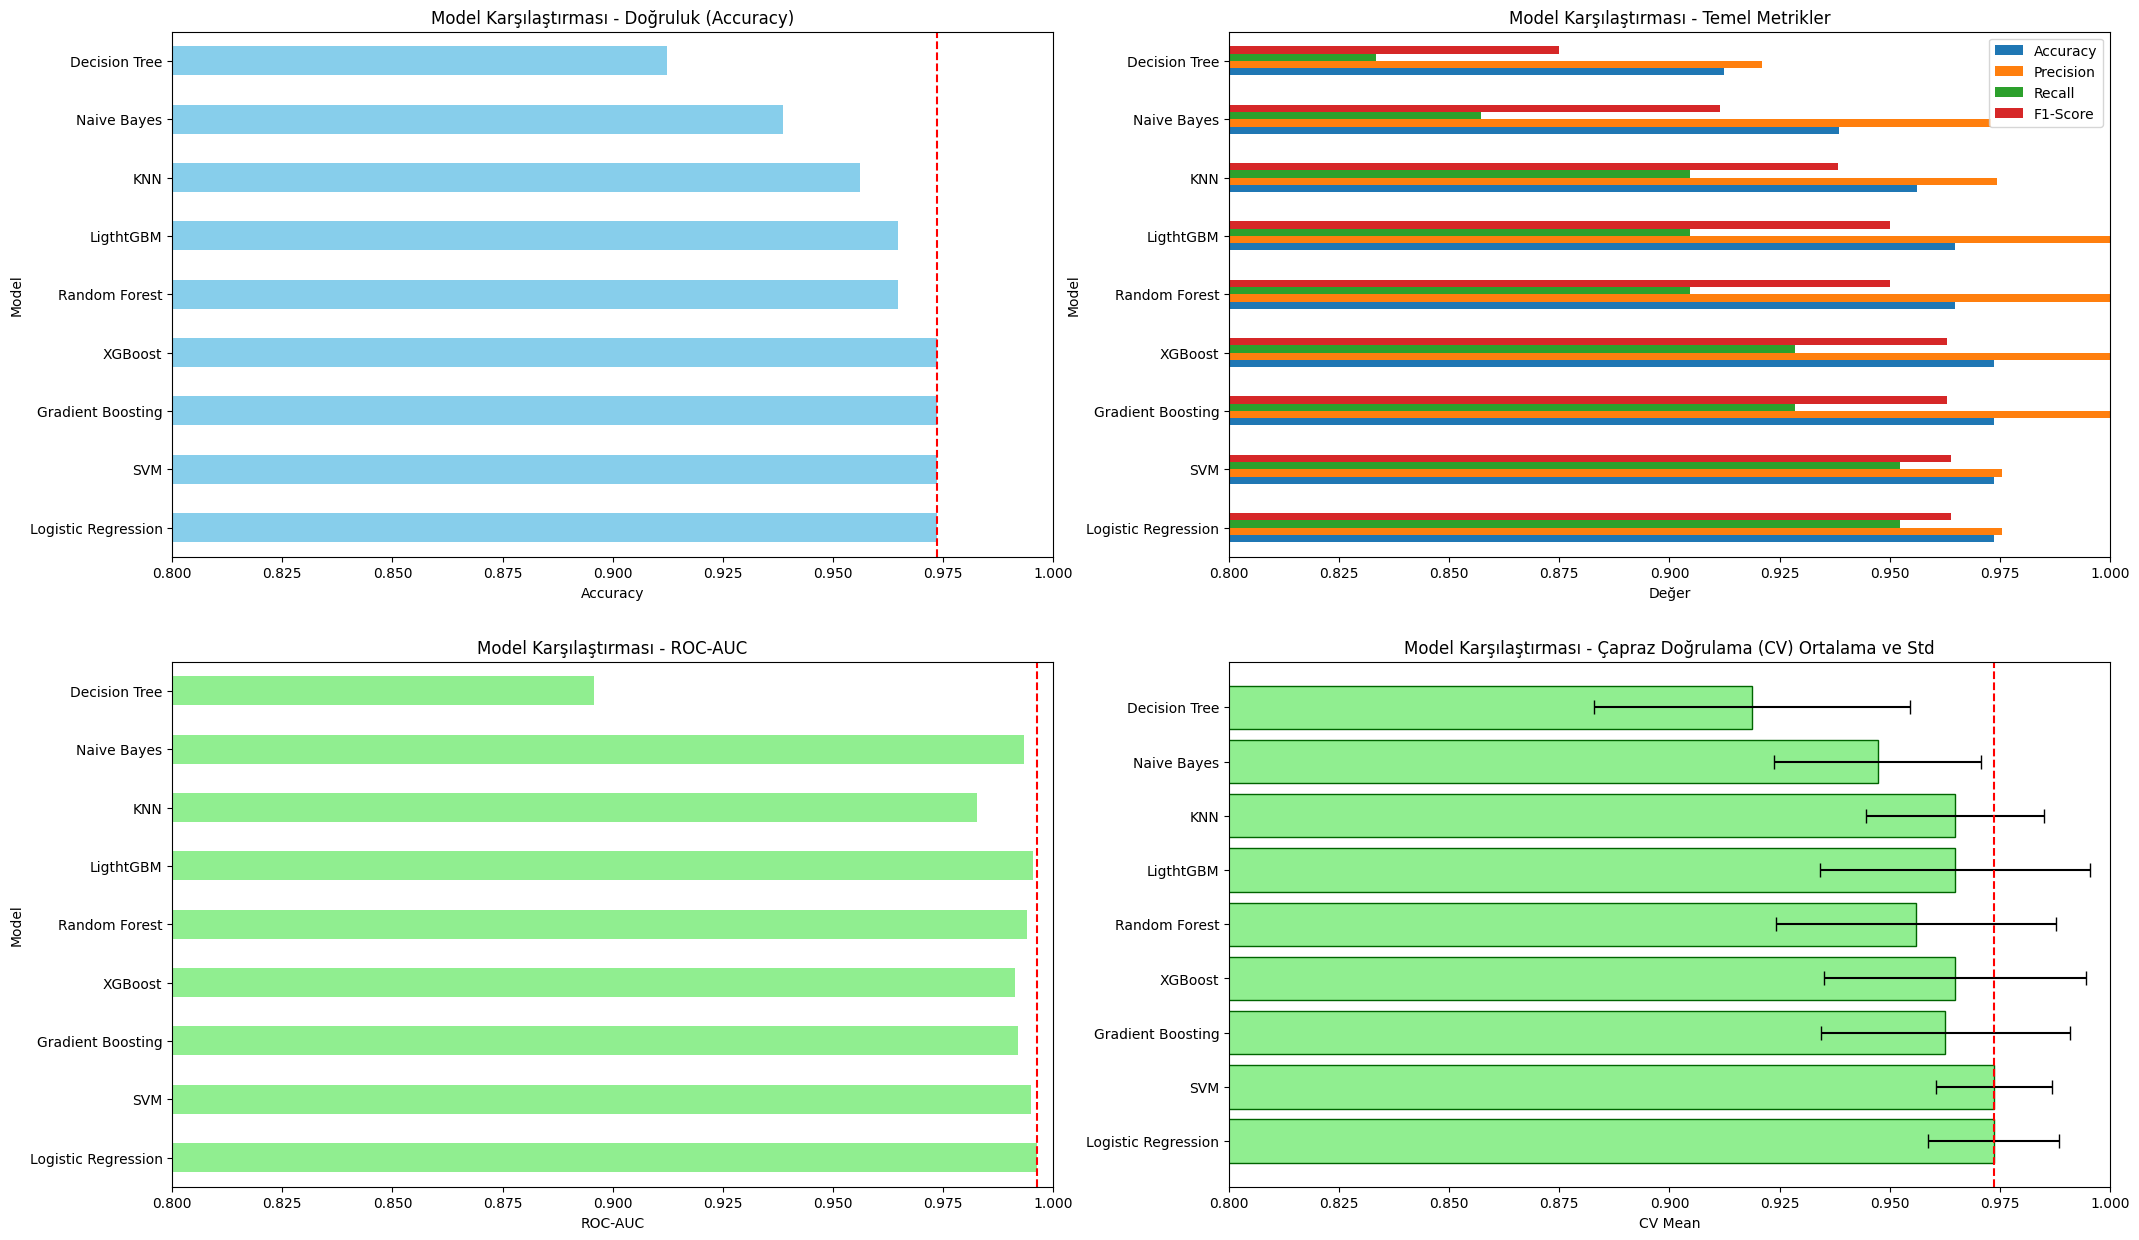

In [118]:
#En iyi Modelin Detaylı Analizi (Logistic Regression)
fig, axes = plt.subplots(2, 2, figsize=(25, 15))

ax1 = axes[0, 0]
model_comparison_df.plot(x='Model', y='Accuracy', kind='barh', ax=ax1, color='skyblue', legend=False)
ax1.axvline(x=results[best_model_name]['Accuracy'], color='r', linestyle='--')
ax1.set_title('Model Karşılaştırması - Doğruluk (Accuracy)')
ax1.set_xlabel('Accuracy')
ax1.set_xlim([0.8, 1.0])

ax2 = axes[0, 1]
metrics_comparison = ["Accuracy", "Precision", "Recall", "F1-Score"]
model_comparison_df.plot(x='Model', y=metrics_comparison, kind='barh', ax=ax2)
ax2.set_title('Model Karşılaştırması - Temel Metrikler')
ax2.set_xlabel('Değer')
ax2.set_xlim([0.8, 1.0])

ax3 = axes[1, 0]
model_comparison_df.plot(x='Model', y='ROC-AUC', kind='barh', ax=ax3, color='lightgreen', legend=False)
ax3.axvline(x=results[best_model_name]['ROC-AUC'], color='r', linestyle='--')
ax3.set_title('Model Karşılaştırması - ROC-AUC')
ax3.set_xlabel('ROC-AUC')
ax3.set_xlim([0.8, 1.0])

ax4 = axes[1, 1]
ax4.barh(model_comparison_df['Model'], model_comparison_df['CV_Mean'], xerr=model_comparison_df['CV_Std'], 
         color='lightgreen', edgecolor='darkgreen', capsize=5)
ax4.axvline(x=results[best_model_name]['CV_Mean'], color='r', linestyle='--')
ax4.set_title('Model Karşılaştırması - Çapraz Doğrulama (CV) Ortalama ve Std')
ax4.set_xlabel('CV Mean')
ax4.set_xlim([0.8, 1.0])

plt.savefig('graphs/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### **Analiz ve Yorumlama**
1. **Karşılaştırma**

    Her model için `Accuray`, `Precision`, `Recall`, `F1-Score`, `ROC-AUC`, `CV-Mean` ve `CV-Std` metrikleri hesaplandı. Sonuçlar arasından **F1-Score' a göre sıralandı**. Çünkü kanser gibi medikal problemlerde hem `Precision` hem de `Recall`' un birlikte değerlendirilmesi çok önemli. 

    Modeller arasından **Logistic Regression** birinci sırada yer aldı.

2. **Grafikli Karşılaştrıma**
   
    - **Accuracy Grafiği (Sol üst)**

        Kırmızı kesikli çizgi ile en yüksek değere sabit olan `Accuracy` değerine endekslendi. Burdan görüyoruzki, ``Logistic Regression``, ``SVM``, `Gradient Boosting`, `XGBoost` ve `LightGBM` **0.9736** gibi bir değerle birinci sırayı paylaşıyor.
    
    - **Temel Metrikler (Sağ üst)**

        Logistic Regression için Precision ve Recall birbirine çok yakın ve yüksek (F1-Score da en üst seviyede):

            Bu şu anlama geliyor: Yanlış pozitiflerin düşük tutuyor, gerçek pozitiflerin çoğunu yakalıyor
            
        Bazı ağaç tabanlı modellerde (Random Forest, Gradient Boosting, XGBoost):
        
            Precision = 1.0 ama Recall biraz daha düşük. Çok az yanlış pozitif var ama bazı malign vakalar kaçabiliyor. F1-Score bu yüzden Logistic Regression’dan hafif aşağıda kalıyor.
    
    - **ROC-AUC Grafiği (Sol alt)**
        
        Logistic Regression ROC-AUC değeri = **0.9964**

        En yakın rakiplerin de (SVM, Gradient Boosting, Random Forest ve XGBoost) 0.99 civarinda

        Logistic Regression, **sınıfları ayırt etme gücü neredeyse mükemmel**

    - **Çapraz Doğrulama Grafiği (Sağ alt)**

        Logistic Regression CV_Mean = 0.9736, CV_Std düşük (katlar arasında fazla dalgalanma yok). Bunun anlamı, Logistic Regression eğitim setinin farklı parçalarında da **tutarlı ve stabil** sonuç veriyor. 

        Bazı modellerin ortalaması yakın olsa da standart sapması daha fazla; bu da Logistic Regression’i **genellenebilirlik** açısından öne çıkarıyor.

Logistic Regression Modeli Detaylı İnceleme:
               precision    recall  f1-score   support

   Benign (0)       0.97      0.99      0.98        72
Malignant (1)       0.98      0.95      0.96        42

     accuracy                           0.97       114
    macro avg       0.97      0.97      0.97       114
 weighted avg       0.97      0.97      0.97       114



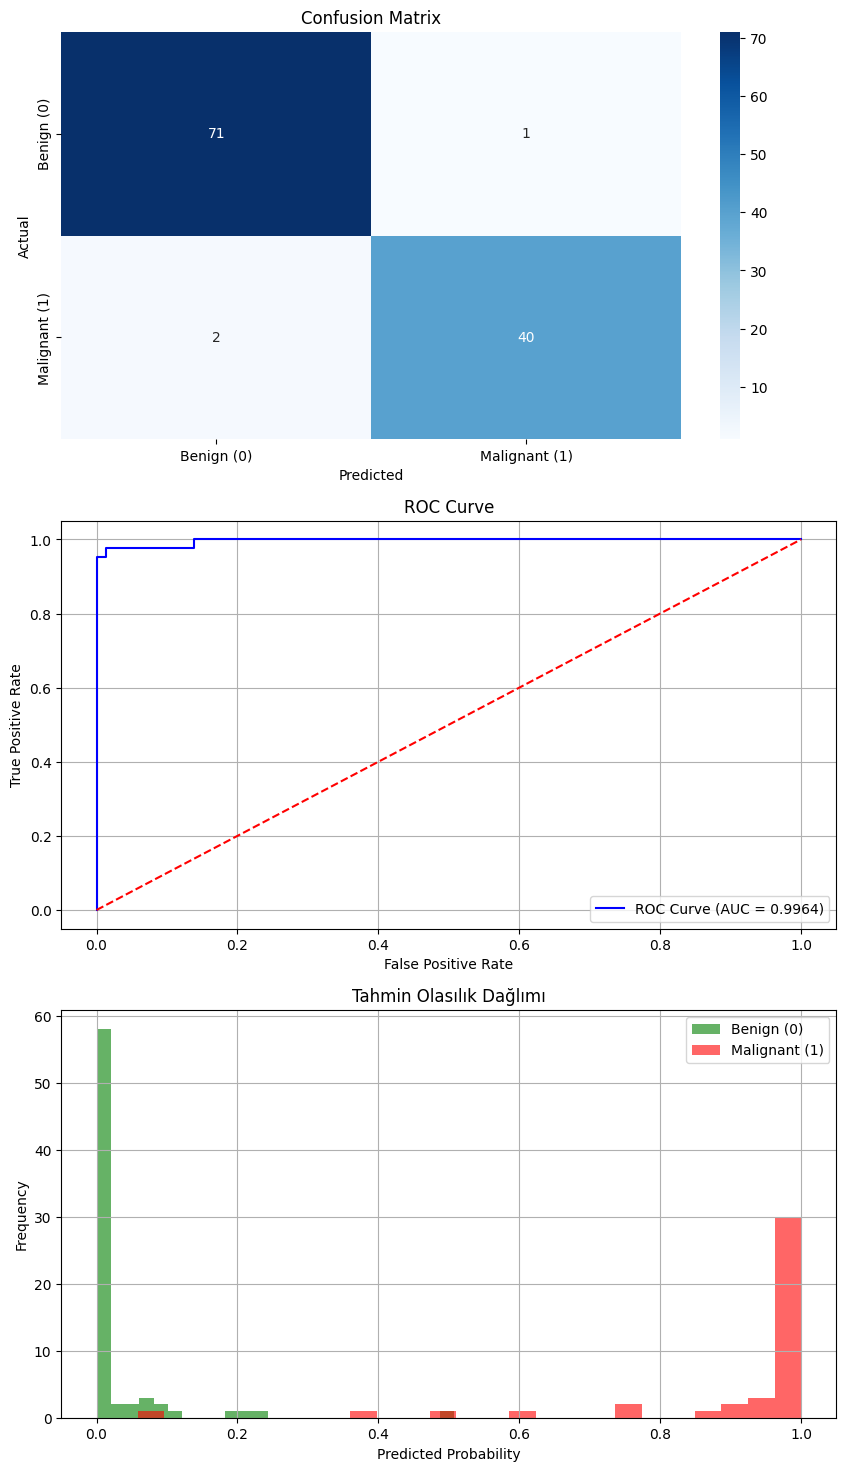

In [119]:
#Logistic Regression Özelinde İnceleme
print(f"{best_model_name} Modeli Detaylı İnceleme:")

y_pred = results[best_model_name]['y_pred']
y_proba = results[best_model_name]['y_proba']

print(classification_report(y_test, y_pred, target_names=['Benign (0)', 'Malignant (1)']))
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(3, 1, figsize=(10, 18))

ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.xaxis.set_ticklabels(['Benign (0)', 'Malignant (1)'])
ax1.yaxis.set_ticklabels(['Benign (0)', 'Malignant (1)'])

ax2 = axes[1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
ax2.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {results[best_model_name]["ROC-AUC"]:.4f})')
ax2.plot([0, 1], [0, 1], color='red', linestyle='--')
ax2.set_title('ROC Curve')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend()
ax2.grid()

ax3 = axes[2]
ax3.hist(y_proba[y_test == 0], bins=25, alpha=0.6, label='Benign (0)', color='green')
ax3.hist(y_proba[y_test == 1], bins=25, alpha=0.6, label='Malignant (1)', color='red')
ax3.set_title('Tahmin Olasılık Dağlımı')
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid()

plt.savefig('graphs/best_model_detailed_analysis.png', dpi=300, bbox_inches='tight')

plt.show()


### **Analiz ve Yorumlama**

1. **Classification Report**
    
- Her iki sınıf için de metrikler 0.95 üstü; model sınıfları dengeli öğrenmiş.

- **Benign**

        Precision (0.97): Model “Benign” dediğinde, %97 oranında gerçekten Benign.
        Recall (0.99): Gerçekte Benign olanların %%99'unu doğru yakalıyor.
        
- **Malign**

        Precision (0.98): Model "Malign" dediğinde %98 oranında gerçekten Malign
        Recall (0.95): Gerçekte Malign olanların %95’ini doğru yakalıyor, %5’sini kaçırıyor.

2. **Confusion Matrix**
    - TN: 71 Benign doğru tahmin edilmiş
    - FP: 1 Benign' e, Malign demiş (yanlış alarm)
    - FN: 2 Malign' a, Benign demiş (kritik hata)
    - TP: 40 Malign doğru tahmin edilmiş

    Sadece 1 iyi huyluya birine kötü huylu demiş. 2 kötü huyluya iyi huylu demiş (medikal açıdan risli bölüm burası - recall).

3. **ROC Curve**
- Eğri neredeyse sol üst köşeye yapışık, AUC = 0.9964, ``threshold`` değişse bile modelin pozitif/negatif ayrımı çok iyi. Bu durum tıbbi kararlarda farklı eşik değerleri denenmek istedniğinde Logistic Regression' un uygunluğunu gösteriyor.

4. **Tahmin Olasılık Dağlımı**
- Sınıfların olasılık dağlımları iyi ayrışmış. (Benign örnekler 0' a kümelenmiş, Malign örnekler 0.8-1 aralığında yoğun gözüküyor).
- Çıktı olasıkları güvenilir yorumlanabilir.



## Adım 8: Hiperparametre Optimizasyonu (Tuning)
Baseline olarak en iyi sonucu veren modeli seçip GridSearchCV ile optimize ediyoruz. (Diğer modellerede uygulanımını gösterdik).

In [120]:
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'num_leaves': [31, 50, 70]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'kernel': ['rbf', 'poly']
    },
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    }
}

if best_model_name in param_grids:
    param_grid = param_grids[best_model_name]
    
    print(f"En iyi model için hiperparametre ayarı yapılıyor")
    for key, values in param_grid.items():
        print(f"  {key}: {values}")
    
    grid_search = GridSearchCV(
        estimator=best_model,
        param_grid=param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"\nEn iyi parametreler:")
    for key, value in grid_search.best_params_.items():
        print(f"  {key}: {value}")
    
    print(f"EN iyi CV Skoru: {grid_search.best_score_:.4f}")
    
    # Evaluate tuned model
    tuned_model = grid_search.best_estimator_
    y_pred_tuned = tuned_model.predict(X_test_scaled)
    y_pred_proba_tuned = tuned_model.predict_proba(X_test_scaled)[:, 1]
    
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    f1_tuned = f1_score(y_test, y_pred_tuned)
    roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
    
    print(f"Ayarlanmış Model Performansı:")
    print(f"  Accuracy: {accuracy_tuned:.4f}")
    print(f"  F1-Score: {f1_tuned:.4f}")
    print(f"  ROC-AUC: {roc_auc_tuned:.4f}")
    
    print(f"Hiperparamtre ayarı sonrası performans iyileşmeleri:")
    print(f"  Accuracy: {(accuracy_tuned - results[best_model_name]['Accuracy'])*100:+.2f}%")
    print(f"  F1-Score: {(f1_tuned - results[best_model_name]['F1-Score'])*100:+.2f}%")
    print(f"  ROC-AUC: {(roc_auc_tuned - results[best_model_name]['ROC-AUC'])*100:+.2f}%")
    
    best_model = tuned_model
    
else:
    print(f"{best_model_name} için GridSearchCV tanımlanmamış")
    print("Orijinal model kullanılıyor...")
    tuned_model = best_model

En iyi model için hiperparametre ayarı yapılıyor
  C: [0.001, 0.01, 0.1, 1, 10, 100]
  penalty: ['l2']
  solver: ['lbfgs', 'liblinear']
Fitting 5 folds for each of 12 candidates, totalling 60 fits

En iyi parametreler:
  C: 10
  penalty: l2
  solver: liblinear
EN iyi CV Skoru: 0.9671
Ayarlanmış Model Performansı:
  Accuracy: 0.9737
  F1-Score: 0.9639
  ROC-AUC: 0.9861
Hiperparamtre ayarı sonrası performans iyileşmeleri:
  Accuracy: +0.00%
  F1-Score: +0.00%
  ROC-AUC: -1.03%


In [121]:
#Ensamble Model Kullanımı
top_models = model_comparison_df.head(3)['Model'].tolist()
print("En İyi 3 Model:", top_models)

estimators = [(name, results[name]['model_name']) for name in top_models]
voting_clf = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
voting_clf.fit(X_train_scaled, y_train)

y_pred_ensamble = voting_clf.predict(X_test_scaled)
y_proba_ensamble = voting_clf.predict_proba(X_test_scaled)[:, 1]

accuracy_ensamble = accuracy_score(y_test, y_pred_ensamble)
precision_ensamble = precision_score(y_test, y_pred_ensamble)
recall_ensamble = recall_score(y_test, y_pred_ensamble)
f1_ensamble = f1_score(y_test, y_pred_ensamble)
roc_auc_ensamble = roc_auc_score(y_test, y_proba_ensamble)

print("\nEnsemble Model Performansı:")
print(f"Accuracy: {accuracy_ensamble:.4f}, Precision: {precision_ensamble:.4f}, Recall: {recall_ensamble:.4f}, F1-Score: {f1_ensamble:.4f}, ROC-AUC: {roc_auc_ensamble:.4f}")



En İyi 3 Model: ['Logistic Regression', 'SVM', 'Gradient Boosting']

Ensemble Model Performansı:
Accuracy: 0.9737, Precision: 1.0000, Recall: 0.9286, F1-Score: 0.9630, ROC-AUC: 0.9954


In [122]:
print(f"Elimizdeki en iyi model {best_model_name} ile Ensamle Model karşılaitırılması")
print(f"Accuracy: {(accuracy_ensamble - results[best_model_name]['Accuracy'])*100:+.2f}%")
print(f"F1-Score: {(f1_ensamble - results[best_model_name]['F1-Score'])*100:+.2f}%")
print(f"ROC-AUC: {(roc_auc_ensamble - results[best_model_name]['ROC-AUC'])*100:+.2f}%")

Elimizdeki en iyi model Logistic Regression ile Ensamle Model karşılaitırılması
Accuracy: +0.00%
F1-Score: -0.09%
ROC-AUC: -0.10%


In [123]:
#Karşılaştıma Sonu

if f1_ensamble > f1_tuned:
    print(f"Ensemble modeli en iyi modelden daha iyi performans gösterdi.")
    final_model = voting_clf
    final_model_name = "Ensemble Model (VotingClassifier)"
    y_pred_final = y_pred_ensamble
    y_proba_final = y_proba_ensamble
else:
    print(f"{best_model_name} modeli en iyi performansı gösterdi.")
    final_model_name = best_model_name
    final_model = tuned_model
    y_pred_final = y_pred_tuned
    y_proba_final = y_pred_proba_tuned

Logistic Regression modeli en iyi performansı gösterdi.


### **Analiz ve Yorumalma
1. **Logistic Regression için GridSearchCV**
- Başlangıç Logistic Regression modeli zaten neredeyse optimum durumda
    - Accuracy: 0.9737 (değişmedi)
    - F1: 0.9639 (değişmedi)
    - ROC-AUC: biraz düştü (= −1.03%)
- GridSearchCV en bir kazanç sağlamadı, baseline ayarların çok iyi olduğunu gösteriyor.

2. **Ensamble (VotingClassifier: Logistic + SVM + Gradient Boosting)**
- Karşılaştırma sonucununa bakılırsa:
    - Accuracy: 0.9737 (LogReg ile aynı)
    - F1-Score: 0.9630 (LogReg’ten −0.09% düşük)
    - ROC-AUC: 0.9954 (LogReg’ten −0.10% düşük)
- "Logistic Regression modeli en iyi performansı gösterdi"

## ADIM 9: Model Açıklanabilirliği
SHAP analizi

SHAP Analizi: Logistic Regression Modeli

SHAP değerleri hesaplandı. Şekil: (114, 33)


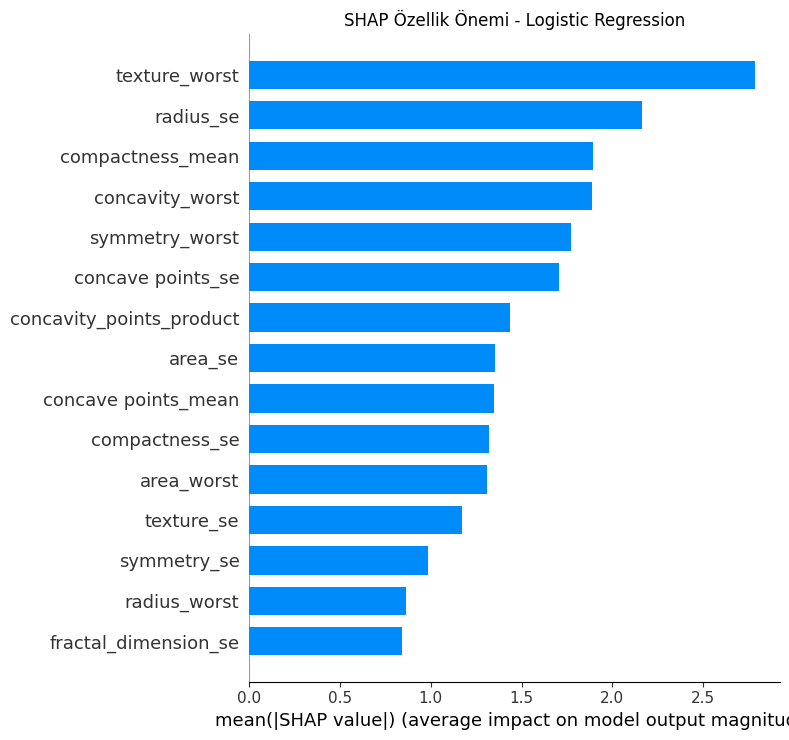

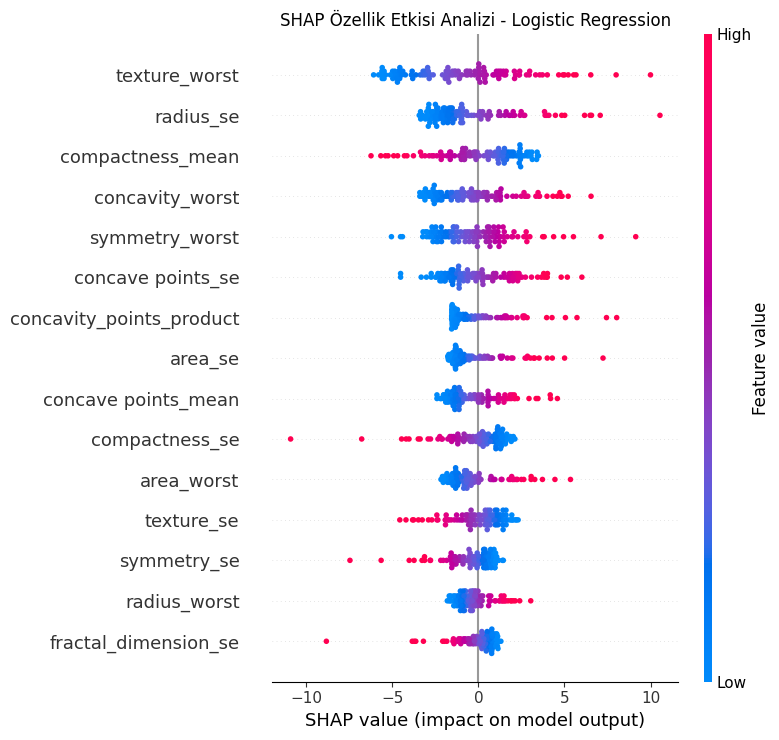

In [125]:
print(f"SHAP Analizi: {best_model_name} Modeli")
explainer = shap.LinearExplainer(best_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

print(f"\nSHAP değerleri hesaplandı. Şekil: {np.array(shap_values).shape}")

# SHAP Summary Plot (Bar) - Özellik önem sıralaması
plt.figure(figsize=(18, 15))
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", show=False, max_display=15)
plt.title(f'SHAP Özellik Önemi - {best_model_name}')
plt.tight_layout()
plt.savefig("graphs/shap_importance.png", dpi=150, bbox_inches='tight')
plt.show()

# SHAP Summary Plot (Dot) - Detaylı özellik etkisi
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_scaled, show=False, max_display=15)
plt.title(f'SHAP Özellik Etkisi Analizi - {best_model_name}')
plt.tight_layout()
plt.savefig("graphs/shap_summary.png", dpi=150, bbox_inches='tight')
plt.show()


### **Analiz ve Yorumlama**
1. **SHAP Özellik Önemi – Logistic Regression**

- Modelin kararlarında en büyük etkiye sahip değişkenler: 
    - Tümör dokusunun en kötü (worst) duruma ait tekstür bilgisi (`texture_worst`)
    - Yarıçapın standart hatası (`radius_se`)
    - Kompaktlık ortalaması (`compactness_mean`)
    - Çentiklenme ve dışbükeylik ile ilgili ölçüler (`concavity_worst`, ``concave points_se``, `concave points_mean`, `concavity_points_product`)
    - Simetri (`symmetry_worst`) ve alan ölçümleri (`area_se`, `area_worst`)

- Daha önce Random Forest ile yapılan feture importance analizini destekleniyor

    - Tümörün **şekil düzensizliği ve boyutu** ile ilgili özellikler, malign/benign ayrımında en kritik faktörler.

2. **SHAP Özellik Etkisi Analizi – Logistic Regression**

- Bu grafiğin yorumlanması şu şekilde yapılır:

    - Bir özellik için **kırmızı noktalar sağda, mavi noktalar solda** yoğunlaşıyorsa:
        - **Yüksek feature değeri** -> Tahmini **malign tarafa** itiyor (pozitif SHAP).
        - **Düşük feature değeri** -> Tahmini **benign tarafa** itiyor (negatif SHAP).

- Bu durumun Logistic Regression modeli için olan yorumlaması:

    - `texture_worst`, `radius_se`, `concavity_worst`, `concave points_`, `area_se`, `area_worst`
        - Yüksek değerler (kırmızı) çoğunlukla pozitif SHAP tarafında -> malign olasılığı artıyor
        - Düşük değerler (mavi) genelde negatif SHAP -> benign yönünde etki ediyor.
    - Özelliklerin hem önem sıralamsı (hnagi özellik daha geniş yayılıyorsa o daha önemlidir) hem de yönü bu grafikte gösterildiği için Logistic Regression kararları oldukça net açıklanıyor. 


## ADIM 10: Final Model Değerlendirmesi
Modeli test verisi üzerinden değerlendirme.

Final Model:  Logistic Regression
Final Model Performansı:
  Accuracy: 0.9737
  Precision: 0.9756
  Recall: 0.9524
  F1-Score: 0.9639
  ROC-AUC: 0.9861


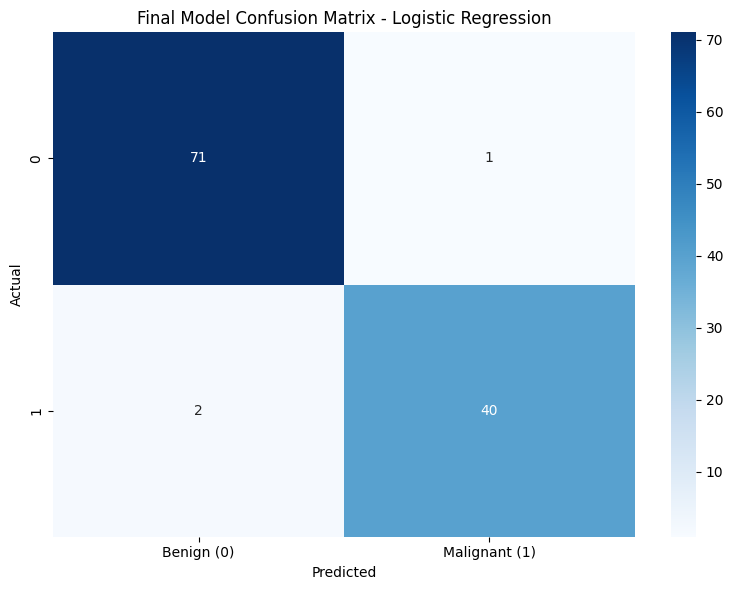

In [127]:
#Final Model Özeti
print("Final Model: ", final_model_name)

final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_proba_final)

print(f"Final Model Performansı:")
print(f"  Accuracy: {final_accuracy:.4f}")
print(f"  Precision: {final_precision:.4f}")
print(f"  Recall: {final_recall:.4f}")
print(f"  F1-Score: {final_f1:.4f}")
print(f"  ROC-AUC: {final_roc_auc:.4f}") 

cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
plt.title(f'Final Model Confusion Matrix - {final_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Benign (0)', 'Malignant (1)'])
plt.tight_layout()
plt.savefig("graphs/final_model_confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

## ADIM 11: Modeli Kaydetme ve Yeni Tahmin
Eğitilmiş pipeline' ı kaydetme ve yeni veriler üzerinden tahmin yapma.

In [130]:
# Tam pipeline: Feature Engineering → StandardScaler → Final Model
final_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('scaler', StandardScaler()),
    ('model', final_model)  # Mevcut final_model'inizi kullanıyoruz
])

# Pipeline'ı eğit (X_train ile, preprocessing otomatik yapılacak)
print(f"Pipeline eğitiliyor (Model: {final_model_name})...")
final_pipeline.fit(X_train, y_train)

# Pipeline ile tahmin yap
y_pred_pipeline = final_pipeline.predict(X_test)
y_proba_pipeline = final_pipeline.predict_proba(X_test)[:, 1]

# Performansı kontrol et
accuracy_pipeline = accuracy_score(y_test, y_pred_pipeline)
f1_pipeline = f1_score(y_test, y_pred_pipeline)
roc_auc_pipeline = roc_auc_score(y_test, y_proba_pipeline)

print(f"\nPipeline Performansı:")
print(f"  Accuracy: {accuracy_pipeline:.4f}")
print(f"  F1-Score: {f1_pipeline:.4f}")
print(f"  ROC-AUC: {roc_auc_pipeline:.4f}")

Pipeline eğitiliyor (Model: Logistic Regression)...

Pipeline Performansı:
  Accuracy: 0.9737
  F1-Score: 0.9639
  ROC-AUC: 0.9861


In [132]:
print("MODEL KAYDETME")

# Pipeline'ı kaydet
model_filename = 'breast_cancer_pipeline.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_pipeline, f)

print(f"Pipeline başarıyla kaydedildi: {model_filename}")

# Model bilgilerini de kaydet (opsiyonel)
model_info = {
    'model_name': final_model_name,
    'accuracy': accuracy_pipeline,
    'f1_score': f1_pipeline,
    'roc_auc': roc_auc_pipeline,
    'feature_names': list(X_train.columns),
    'created_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}
info_filename = 'model_info.pkl'
with open(info_filename, 'wb') as f:
    pickle.dump(model_info, f)

print(f"Model bilgileri kaydedildi: {info_filename}")

MODEL KAYDETME
Pipeline başarıyla kaydedildi: breast_cancer_pipeline.pkl
Model bilgileri kaydedildi: model_info.pkl


In [134]:
print("MODEL YÜKLEME")

# Model'i yükle (test için)
loaded_pipeline = pickle.load(open(model_filename, 'rb'))
loaded_info = pickle.load(open(info_filename, 'rb'))

print(f"Pipeline yüklendi: {loaded_info['model_name']}")
print(f"Model performansı: Accuracy={loaded_info['accuracy']:.4f}, F1={loaded_info['f1_score']:.4f}")

print("\nModel kaydetme/yükleme işlemi tamamlandı!")

MODEL YÜKLEME
Pipeline yüklendi: Logistic Regression
Model performansı: Accuracy=0.9737, F1=0.9639

Model kaydetme/yükleme işlemi tamamlandı!


In [135]:
print("YENİ VERİ İLE TAHMİN YAPMA")

# Örnek: Test setinden birkaç örnek al
print("\nÖrnek: Test setinden 5 örnek alınıyor...\n")
yeni_veri = X_test.head(5).copy()


# Pipeline ile tahmin yap (Preprocessing otomatik yapılacak!)
print("PIPELINE İLE TAHMİN YAPILIYOR...")

#Kaydedilmiş pipeline'ı yükle ve kullan
loaded_pipeline = pickle.load(open('breast_cancer_pipeline.pkl', 'rb'))
tahminler = loaded_pipeline.predict(yeni_veri)
olasiliklar = loaded_pipeline.predict_proba(yeni_veri)[:, 1]

# Sonuçları göster
sonuclar = pd.DataFrame({
    'Tahmin': tahminler,
    'Olasılık (Malignant)': olasiliklar,
    'Gerçek Değer': y_test.iloc[:5].values,
    'Doğru mu?': (tahminler == y_test.iloc[:5].values)
})

print("\nTahmin Sonuçları:")
print(sonuclar.to_string(index=False))

YENİ VERİ İLE TAHMİN YAPMA

Örnek: Test setinden 5 örnek alınıyor...

PIPELINE İLE TAHMİN YAPILIYOR...

Tahmin Sonuçları:
 Tahmin  Olasılık (Malignant)  Gerçek Değer  Doğru mu?
      0              0.000012             0       True
      1              1.000000             1       True
      0              0.001235             0       True
      1              0.531458             1       True
      1              0.803489             0      False


### **Analiz ve Yorumlama**
- İlk 4 örnekte hem sınıf tahmini, hem de olasılıklar tıbbi olarak mantıklı:
    - Benign örneklerde olasılıklar neredeyse 0,
    - Malign örneklerde 0.53 ve 1.00 gibi yüksek değerler.
- Sadece 5. örnekte:
    - Model malign (1) demiş, olasılık 0.80,
    - Gerçek etiket benign (0) → tek yanlış sınıflama.
- Bu yanlış sınıflama:
    - Daha önce confusion matrix’te gördüğün yanlış pozitif örneklerden birine denk geliyor.
    - Model bu hastayı, özellikleri itibariyle “riskli” görmüş; 0.80 olasılıkla malign demiş, fakat gerçekte benign çıkmış.
    - yanlış pozitif çok medikal açıdan çok kritik bir durum değil. Fakat yanlış negatif (hasta birine sağlıklı demek) çok daha kritik bir durum